In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fastai

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/MachineHack/CatVsDog Computervision/Data.zip","r") as zip_ref:
    zip_ref.extractall("input")


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
print(os.listdir("input/Data"))
import shutil 
newpath = r'/content/input/Data/Train/images' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
print(os.listdir("input/Data/Train"))
# Any results you write to the current directory are saved as output.

['Sample_Submission.csv', 'Train', 'Train.csv', 'Test', '.DS_Store']
['Dogs', 'Cats', '.DS_Store', 'images']


In [ ]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [ ]:
data_folder = Path("input/Data/Train/")

In [ ]:
data_path = "input/Data/Train/images/"
path = os.path.join(data_path , "*jpg")

In [ ]:
dir = os.listdir("input/Data/Train/Cats")
len(dir)

4747

# Getting the data Ready in my convinient format

In [ ]:
mypath = "input/Data/Train/Dogs"
for root, dirs, files in os.walk(mypath):
    for file in files:
      src = mypath+"/"+file
      dst = "input/Data/Train/images"
      shutil.move(src, dst) 

In [ ]:
mypath = "input/Data/Train/Cats"
for root, dirs, files in os.walk(mypath):
    for file in files:
      src = mypath+"/"+file
      dst = "input/Data/Train/images"
      shutil.move(src, dst)

In [ ]:
mypath = "input/Data/Test"
for root, dirs, files in os.walk(mypath):
    for file in files:
      src = mypath+"/"+file
      dst = "input/Data/Train/images"
      shutil.move(src, dst)

In [ ]:
train_df = pd.read_csv('input/Data/Train.csv')
test_df = pd.read_csv('/content/input/Data/Sample_Submission.csv')["File_Name"].to_frame()
submit = pd.read_csv('/content/input/Data/Sample_Submission.csv')

In [ ]:
train_df

,File_Name,Category
0,10846.jpg,1
1,2360.jpg,1
2,17531.jpg,0
3,13254.jpg,1
4,15554.jpg,0
...,...,...
9466,7292.jpg,0
9467,18042.jpg,1
9468,4048.jpg,0
9469,20605.jpg,1


In [ ]:
test_df

,File_Name
0,8121.jpg
1,15486.jpg
2,8132.jpg
3,16297.jpg
4,20838.jpg
...,...
4054,15376.jpg
4055,19489.jpg
4056,9762.jpg
4057,1423.jpg


# Checking images with OpenCV

In [ ]:
train_imagesdf=[]
for file1 in train_df["File_Name"].values:
      image = cv2.imread("/content/input/Data/Train/images/"+file1)
      train_imagesdf.append(image)
test_imagesdf=[]
for file1 in test_df["File_Name"].values:
      image = cv2.imread("/content/input/Data/Train/images/"+file1)
      test_imagesdf.append(image)

In [ ]:
dir = os.listdir("input/Data/Train/images")
len(dir)

13530

In [ ]:
train_df.shape, test_df.shape

((9471, 2), (4059, 1))

In [ ]:
# plt.imshow(train_imagesdf[10])

In [ ]:
# plt.imshow(test_imagesdf[1])

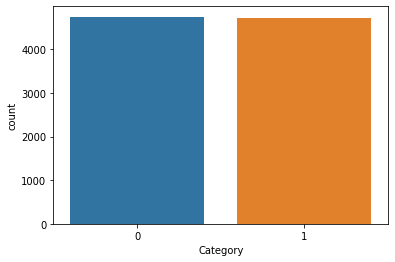

In [ ]:
sns.countplot(x='Category' , data=train_df)

In [ ]:
# train_images = train_imagesdf
# test_images= test_imagesdf

# Transformations!

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

test_img = ImageList.from_df(test_df, path=data_folder, folder='images')

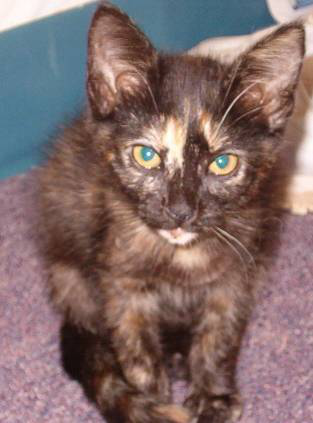

In [ ]:
test_img[0]

In [ ]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path=data_folder, folder='images')
       .split_by_rand_pct(0.2)
      #  .split_none()
       .label_from_df()
       .add_test(test_img))

In [ ]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

In [ ]:
print(data.classes)

[0, 1]


In [ ]:
#resnet152, densenet201, resnet101 ,resnet50
# learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
#                     callback_fns=ShowGraph)
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

In [ ]:
learn.summary()

epoch,train_loss,valid_loss,f_beta,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 3.31E-03


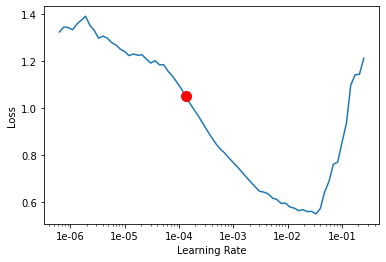

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

# Training

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.105845,0.026332,0.994715,0.994720,06:46
1,0.041690,0.006168,0.997886,0.997888,06:46
2,0.032022,0.010554,0.996301,0.996304,06:45
3,0.019098,0.009159,0.996301,0.996304,06:45


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

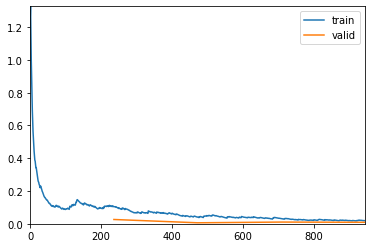

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [ ]:
lr = 3e-03
learn.fit_one_cycle(4, slice(lr), wd=0.2)

with lower learning rate training again

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.022154,0.007759,0.997886,0.997888,06:44


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

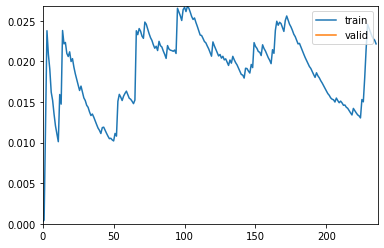

In [ ]:
learn.fit_one_cycle(1, slice(lr/2), wd=0.2)

Export

In [ ]:
learn.export(file = Path("/content/drive/My Drive/Colab Notebooks/MachineHack/CatVsDog Computervision/export.pkl"))

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

Plot

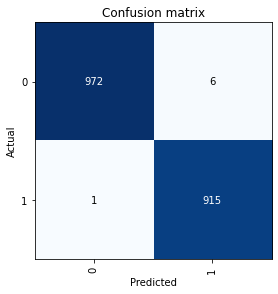

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[(0, 1, 6), (1, 0, 1)]

In [ ]:
# pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
# from sklearn.metrics import f1_score, accuracy_score
# valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
# valid_preds = np.array(valid_preds)
# y = np.array(y+1)
# accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='micro')

# Predictions

In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Test) # 
# preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [ ]:
preddf = pd.DataFrame(np.array(preds))

In [ ]:
df = pd.DataFrame({'File_Name':test_df['File_Name'], 'Category':labelled_preds})
df["Category"] = df["Category"].astype(int)
df["File_Name"] = df["File_Name"].astype(str)
df.to_excel('submission5.xlsx', index=False)

In [ ]:
df

,File_Name,Category
0,8121.jpg,0
1,15486.jpg,0
2,8132.jpg,0
3,16297.jpg,1
4,20838.jpg,1
...,...,...
4054,15376.jpg,0
4055,19489.jpg,1
4056,9762.jpg,0
4057,1423.jpg,0
